In [1]:
import numpy as np 
import math 
import matplotlib.pyplot as plt
from itertools import combinations, product
from scipy.spatial.transform import Rotation as R
import pickle
from mpl_toolkits.mplot3d import Axes3D
import copy
import multiprocessing as mp
from matplotlib.colors import Normalize

Prepare lattice vector for projection plane and create corresponding slab model.

In [2]:
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

c_001 = np.array([0,0,1])
c_target = np.array([1,3,5])

c_cross = np.cross(c_target, c_001)
c_cross = c_cross/np.linalg.norm(c_cross)
c_angle = np.arccos(np.dot(c_target, c_001)/(np.linalg.norm(c_001)*np.linalg.norm(c_target)))

r = R.from_rotvec(c_cross*c_angle)

fcc_001_matrix = 1/2*np.array([
    [0,1,1],
    [1,0,1],
    [1,1,0],
])

fcc_matrix = r.inv().apply(fcc_001_matrix)

#* Define the fraction coordinates.
cart_, cart_pbc = [], []
#* Define x, y, z axis's range.
def cart_make(fcc_matrix, frac_range):
    cart_ = []
    for i, j, k in product(frac_range, repeat=3):
        frac_ = np.array([[i,j,k]])
        cart__ = np.dot(frac_, fcc_matrix)[0]
        cart_.append(cart__)
        
    return np.array(cart_)

num_primcell = 4
cart_raw = cart_make(fcc_matrix, np.arange(num_primcell))
cart_ = cart_make(fcc_matrix, np.arange(-num_primcell, num_primcell*2))

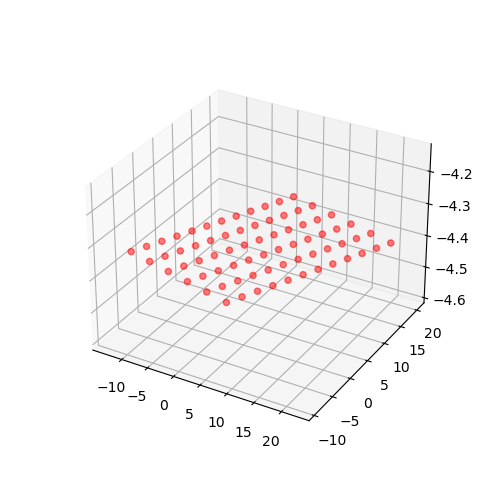

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [6]:
%matplotlib widget 
cart_bot_frac = cart_bot@np.linalg.inv(fcc_matrix)/lp_au
# draw_3d(((cart_cartesian@np.linalg.inv(fcc_matrix))))
draw_3d(cart_bot)

Define the slip vector, choose a common slip pattern.

In [54]:
fcc_matrix

array([[ 1.03553391e-01,  6.03553391e-01, -3.53553391e-01],
       [ 6.03553391e-01,  1.03553391e-01, -3.53553391e-01],
       [ 5.55111512e-17,  5.55111512e-17, -7.07106781e-01]])

##### 重なり体積 of fcc

- Define top $N/2$ layers as in motion.

- In this simple demonstration, use **top+bottom** layer near interface for volume accounting. ($l_{bot} + 1/N\sum_{dx}^N l_{top}-l$, where $l=a/\sqrt{h^2+k2+l^2}$) 

- Volume per each grid within one atom will be $2(dx)^2\sqrt{r^2-(mdx)^2}$ by approximation. (Analytic solution as $\int \int \sqrt{r_0^2-(x-x_0)^2-(y-y_0)^2}\mathrm{d}x\mathrm{d}y$ might be non-trivial for grid intergration because the lack of closed loop.)

- To prevent singularity considering of PBC?
  - Idea 1: PBC will be implemented during slip as $R_{PBC}=\mathrm{mod}[(R_c+m\vec{v})A^{-1}, R_f]A$ since $R_f$ must be in cubic form.
  - Idea 2: Make PBC confugration (possibly 3x3x3) and only take account of centre config.

- Partial dislocation is interpreted as $a/2[10\bar{1}]=a/6[11\bar{2}]+a/6[2\bar{1}\bar{1}]$

In [55]:
def angle_calc(v1, v2):
    angle = np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    return angle, np.rad2deg(angle)

angle_calc(np.array([0,0,1]), np.array([1,1,0]))

(1.5707963267948966, 90.0)

In [3]:
slip_vector_001 = np.array([0,1,-1])
slip_vector_ = np.round(r.apply(slip_vector_001), 4)

au_radii = 1.28 #* Angstrom
lp_au = 2*math.sqrt(2)*au_radii #* Angstrom
layer_distance = lp_au/np.linalg.norm(c_target) #* Angstrom, layer distance
cart_cartesian, cart_cartesian_raw = cart_*lp_au, cart_raw*lp_au #* Cartesian coordinates for slab model
lp_supercell_001 = lp_au*(num_primcell) #* Lattice parameter (R_f) of supercell in [001] zone axis.
cell_fcc = np.array([lp_supercell_001, lp_supercell_001, lp_supercell_001]) #* FCC unit cell

ds_norm = au_radii/(10*math.sqrt(6)) #* Step per slip operation.
# grid_square = ds_norm**2 #* Grid square

slip_vector_norm = slip_vector_/np.linalg.norm(slip_vector_)
ds_ = ds_norm*slip_vector_norm #* Step vector
burgers_vector = lp_au/6*2.5*math.sqrt(3) #* Define burgers vector and its multiplication (total displacement).
ds_num = int(np.ceil(burgers_vector/ds_norm))

z_coords = np.unique(np.round(cart_cartesian[:,2], 4))
bot_ind, up_ind = len(z_coords)//2, len(z_coords)//2+1
target_layer_bot = np.where(np.abs(cart_cartesian[:,2]-z_coords[bot_ind]) < 0.001)[0] #* Static plane
target_layer_top = np.where(np.abs(cart_cartesian[:,2]-z_coords[up_ind]) < 0.001)[0] #* Slip plane

cart_bot, cart_target = cart_cartesian[target_layer_bot], cart_cartesian[target_layer_top]
cart_slip = np.concatenate((cart_bot, cart_target), axis=0)

#* Define x_min, x_max, y_min, y_max
x_min, x_max = np.min(cart_cartesian[:,0]), np.max(cart_cartesian[:,0])
y_min, y_max = np.min(cart_cartesian[:,1]), np.max(cart_cartesian[:,1])

x_min_raw, x_max_raw = np.min(cart_cartesian_raw[:,0]), np.max(cart_cartesian_raw[:,0])
y_min_raw, y_max_raw = np.min(cart_cartesian_raw[:,1]), np.max(cart_cartesian_raw[:,1])

#* Seperate plane into grids by defining [x_min, x_max] and [y_min, y_max]
dN = int(np.ceil((np.linalg.norm([y_max-y_min, x_max-x_min]))/ds_norm))
dict_grid, dict_grid_list = {}, {}
for i, j in product(range(dN), repeat=2):
    dN_x = x_min + i*ds_norm
    dN_y = y_min + j*ds_norm
    dN_x_ = x_min + (i+1)*ds_norm
    dN_y_ = y_min + (j+1)*ds_norm
    dict_grid[dN_x, dN_x_, dN_y, dN_y_] = 0
    dict_grid_list[dN_x, dN_x_, dN_y, dN_y_] = []

#* Raw grid and x,y-coordinates' range.
dN_raw = int(np.ceil((np.linalg.norm([y_max_raw-y_min_raw, x_max_raw-x_min_raw]))/ds_norm))
dict_grid_raw = {}
for i, j in product(range(dN_raw), repeat=2):
    dN_x = x_min_raw + i*ds_norm
    dN_y = y_min_raw + j*ds_norm
    dN_x_ = x_min_raw + (i+1)*ds_norm
    dN_y_ = y_min_raw + (j+1)*ds_norm
    dict_grid_raw[dN_x, dN_x_, dN_y, dN_y_] = 0    

#* Create an empty list to store the volume of each 'grid' during slip.
V_total_image = {}

#* Return the valid index surround the target atom.
num_dx_atom = int(np.ceil(au_radii/ds_norm))+1
valid_surround_ind, valid_surround_dict = [], {}
for j, k in product(range(-num_dx_atom, num_dx_atom), repeat=2):
    atom_surround_relative = np.array([j*ds_norm, k*ds_norm, 0])
    if np.linalg.norm(atom_surround_relative) < au_radii:
        valid_surround_ind.append([j,k])
        v_grid = 2*np.sqrt(au_radii**2-np.linalg.norm([j*ds_norm, k*ds_norm])**2)
        valid_surround_dict[j,k] = v_grid

        
#* Get x, y list of grid.
dict_grid_keys = list(dict_grid.keys())
x_list, y_list = [], []

for i in range(len(dict_grid_keys)):
    x_min_, x_max_, y_min_, y_max_ = dict_grid_keys[i]
    x_list.append([x_min_, x_max_])
    y_list.append([y_min_, y_max_])
    
x_list = np.unique(np.array(x_list).flatten())
y_list = np.unique(np.array(y_list).flatten())

dict_grid_keys_raw = list(dict_grid_raw.keys())
x_list_raw, y_list_raw = [], []

for i in range(len(dict_grid_keys_raw)):
    x_min_, x_max_, y_min_, y_max_ = dict_grid_keys_raw[i]
    x_list_raw.append([x_min_, x_max_])
    y_list_raw.append([y_min_, y_max_])
    
x_list_raw = np.unique(np.array(x_list_raw).flatten())
y_list_raw = np.unique(np.array(y_list_raw).flatten())

#* New dict mapping [ind_x, ind_y] -> {key} for key in dict_grid.
dict_grid_ind = {}
for i, j in product(range(len(x_list)-1), repeat=2):
    dict_grid_ind[i, j] = (x_list[i], x_list[i+1], y_list[j], y_list[j+1])
    
def pbc_calib(image, fcc_matrix):
    cell_001 = image@np.linalg.inv(fcc_matrix)

    #* Calibration of out-PBC atoms.
    out_pbc_ind = np.where((cell_001 < -1e-2) | (cell_001 > lp_supercell_001+1e-2))
    cell_001[out_pbc_ind] = cell_001[out_pbc_ind] % lp_supercell_001

    cell_calib_image = cell_001@fcc_matrix
    
    return cell_calib_image

#* Calculate volume of each image.
def volume_image(cart_image, dict_grid_input, dict_grid_list_=None,
                x_list_=None, y_list_=None):
    
    #? Important: deepcopy for dict.
    if dict_grid_list_ is None:
        dict_grid_list_ = copy.deepcopy(dict_grid_list) #* store the density value per grid and average them in the last. 
    
    if x_list_ is None:
        x_list_ = x_list
        
    if y_list_ is None:
        y_list_ = y_list
        
    #* New dict mapping [ind_x, ind_y] -> {key} for key in dict_grid.
    dict_grid_ind = {}
    for i, j in product(range(len(x_list_)-1), repeat=2):
        dict_grid_ind[i, j] = (x_list_[i], x_list_[i+1], y_list_[j], y_list_[j+1])
    
    for i in range(len(cart_image)):
        atom_ = cart_image[i]
        x_list_min, x_list_max, y_list_min, y_list_max = x_list_[0], x_list_[-1], y_list_[0], y_list_[-1]
        for surround_grid in valid_surround_ind:
            surround_vector = np.array([surround_grid[0]*ds_norm, surround_grid[1]*ds_norm, 0])
            atom_surround = atom_ + surround_vector
            #? Volume density?
            # v_grid = grid_square*2*math.sqrt(au_radii**2-np.linalg.norm(surround_vector)**2)
            # v_grid = 2*np.sqrt(au_radii**2-np.linalg.norm(surround_vector[:2])**2)
            v_grid = valid_surround_dict[surround_grid[0], surround_grid[1]]
            x_surround, y_surround = atom_surround[0], atom_surround[1]
            
            if (x_list_min <= x_surround <= x_list_max 
                and y_list_min <= y_surround <= y_list_max):
                
                x_gridind = np.where((x_list-x_surround) <= 0)[0][-1]
                y_gridind = np.where((y_list-y_surround) <= 0)[0][-1]
                correspond_dict_grid_ind = dict_grid_ind[x_gridind, y_gridind]
            
                dict_grid_list_[correspond_dict_grid_ind].append(v_grid)
            # super_grid[key_surround] = super_grid.get(key_surround, 0) + v_grid
    
    for key, value in dict_grid_list_.items():
        if len(value) >= 1:
            dict_grid_input[key] += np.mean(value)
            # dict_grid_input[key] += np.max(value)
    
    del dict_grid_list_
    
    return dict_grid_input

#* Calculate overlapped volume for each image.
def overlap_volume_image(cart_image, dict_grid_input, dict_grid_raw, overlap_dict_grid=None):
    
    #? Important: deepcopy for dict.
    dict_grid_list_ = copy.deepcopy(dict_grid_list) #* store the density value per grid and average them in the last. 
    
    for i in range(len(cart_image)):
        atom_ = cart_image[i]
        x_list_min, x_list_max, y_list_min, y_list_max = x_list_raw[0], x_list_raw[-1], y_list_raw[0], y_list_raw[-1]
        for surround_grid in valid_surround_ind:
            surround_vector = np.array([surround_grid[0]*ds_norm, surround_grid[1]*ds_norm, 0])
            atom_surround = atom_ + surround_vector
            #? Volume density?
            # v_grid = grid_square*2*math.sqrt(au_radii**2-np.linalg.norm(surround_vector)**2)
            # v_grid = 2*np.sqrt(au_radii**2-np.linalg.norm(surround_vector[:2])**2)
            v_grid = valid_surround_dict[surround_grid[0], surround_grid[1]]
            x_surround, y_surround = atom_surround[0], atom_surround[1]
            
            if (x_list_min <= x_surround <= x_list_max 
                and y_list_min <= y_surround <= y_list_max):
                
                x_gridind = np.where((x_list-x_surround) <= 0)[0][-1]
                y_gridind = np.where((y_list-y_surround) <= 0)[0][-1]
                correspond_dict_grid_ind = dict_grid_ind[x_gridind, y_gridind]
            
                dict_grid_list_[correspond_dict_grid_ind].append(v_grid)
            # super_grid[key_surround] = super_grid.get(key_surround, 0) + v_grid
    
    for key, value in dict_grid_list_.items():
        if len(value) >= 1:
            dict_grid_input[key] += np.mean(value)
            # dict_grid_input[key] += np.max(value)
    
    if overlap_dict_grid is None:
        overlap_dict_grid = {}
    
    overlap_vol_list = []
    for key, value in dict_grid_input.items():
        total_volume = (dict_grid_raw[key] + value)/2
        overlap_volume = np.clip(total_volume - layer_distance, 0, None)
        
        overlap_vol_list.append(overlap_volume)
        
        key_x = np.sum(key[:2])/2
        key_y = np.sum(key[2:])/2
        key_overlap = (key_x, key_y)
        overlap_dict_grid[key_overlap] =  overlap_dict_grid.get(key_overlap, 0) + overlap_volume
    
    del dict_grid_list_
    
    return overlap_dict_grid, np.mean(overlap_vol_list)

#### Main part.

For the overlapped volume. It should be demonstrated as $\rho(V) (\AA^3/\AA^2)-b (\AA)$ plot as well as $(x,y)-\rho(V)$ heatmap.

In [ ]:
dict_grid_raw_ = copy.deepcopy(dict_grid)
dict_grid_raw_ = volume_image(cart_bot, dict_grid_raw_, x_list_=x_list_raw, y_list_=y_list_raw)

mean_vol_list, b_list = [], []
overlap_dict_grid = {}
for ds_i in range(ds_num):
    cart_target_ = cart_target.copy()
    cart_image = cart_target_ + ds_i*ds_
    #* Calibration of cell by PBC.
    cart_image = pbc_calib(cart_image, fcc_matrix)
    dict_grid_overlapinput = copy.deepcopy(dict_grid)
    overlap_dict_grid, mean_vol = overlap_volume_image(
        cart_image, dict_grid_overlapinput, 
        dict_grid_raw_, overlap_dict_grid=overlap_dict_grid)
    
    mean_vol_list.append(mean_vol)
    b_list.append(ds_i*ds_norm)
    
x_specify_plot, y_specify_plot, volume_specify_list = [], [], []
for key, value in overlap_dict_grid.items():
    x_specify_plot.append(key[0])
    y_specify_plot.append(key[1])
    volume_specify_list.append(value/ds_num)

In [4]:
# #TODO multiprocessing

dict_grid_raw_ = copy.deepcopy(dict_grid)
dict_grid_raw_ = volume_image(cart_bot, dict_grid_raw_,)

def main(ds_i):
    cart_target_ = copy.deepcopy(cart_target)
    cart_image = cart_target_ + ds_i*ds_
    #* Calibration of cell by PBC.
    # cart_image = pbc_calib(cart_image, fcc_matrix)
    dict_grid_overlapinput = copy.deepcopy(dict_grid)
    overlap_dict_grid, mean_vol = overlap_volume_image(
        cart_image, dict_grid_overlapinput, 
        dict_grid_raw_, overlap_dict_grid=None)
    
    # mean_vol_list.append(mean_vol)
    # b_list.append(ds_i*ds_norm)
    
    del cart_target_, cart_image, dict_grid_overlapinput 
    
    return overlap_dict_grid, mean_vol, ds_i*ds_norm

#* Main
max_work = 16
pool = mp.Pool(processes=max_work)
output_list = [pool.map(main, range(ds_num))]

#* Post processing
mean_vol_list, b_list = [], []
overlap_dict_grid = {}
for output in output_list[0]:
    dict_output = output[0]
    mean_vol = output[1]
    displacement_ = output[2]
    
    mean_vol_list.append(mean_vol)
    b_list.append(displacement_)
    for key, value in dict_output.items():
        overlap_dict_grid[key] = overlap_dict_grid.get(key, 0) + value
        
x_specify_plot, y_specify_plot, volume_specify_list = [], [], []
for key, value in overlap_dict_grid.items():
    x_specify_plot.append(key[0])
    y_specify_plot.append(key[1])
    volume_specify_list.append(value/ds_num)

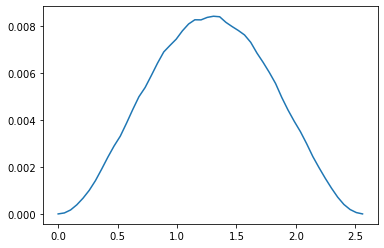

In [11]:
%matplotlib inline 

plt.plot(b_list, mean_vol_list)

Specify the displacement $b$ and check the heatmap of density of overlapped volume.

In [402]:
dict_grid_raw = copy.deepcopy(dict_grid)
#! Must add PBC images of bot layer to prevent singularity.
dict_grid_raw = volume_image(cart_bot, dict_grid_raw)

burgers_vector_specify = lp_au/6*2.5
vector_slip_total = slip_vector_norm*burgers_vector_specify
cart_specify = cart_target + vector_slip_total
cart_specify = pbc_calib(cart_specify, fcc_matrix)
dict_grid_overlapinput = copy.deepcopy(dict_grid)

dict_grid_overlap, mean_vol = overlap_volume_image(cart_specify, dict_grid_overlapinput, dict_grid_raw)

x_specify_plot, y_specify_plot, volume_specify_list = [], [], []
for key, value in dict_grid_overlap.items():
    x_specify_plot.append(key[0])
    y_specify_plot.append(key[1])
    volume_specify_list.append(value)

In [29]:
with open('./crystal_overlap/utils/dict_grid_fin.pickle', 'wb') as f:
    pickle.dump(dict_grid_fin, f)
with open('./utils/dict_grid_raw.pickle', 'wb') as f:
    pickle.dump(dict_grid_raw_fin, f)

In [30]:
with open('./crystal_overlap/utils/dict_grid_fin.pickle', 'rb') as f:
    dict_grid_fin = pickle.load(f)
with open('./crystal_overlap/utils/dict_grid_raw.pickle', 'rb') as f:
    dict_grid_raw_fin = pickle.load(f)

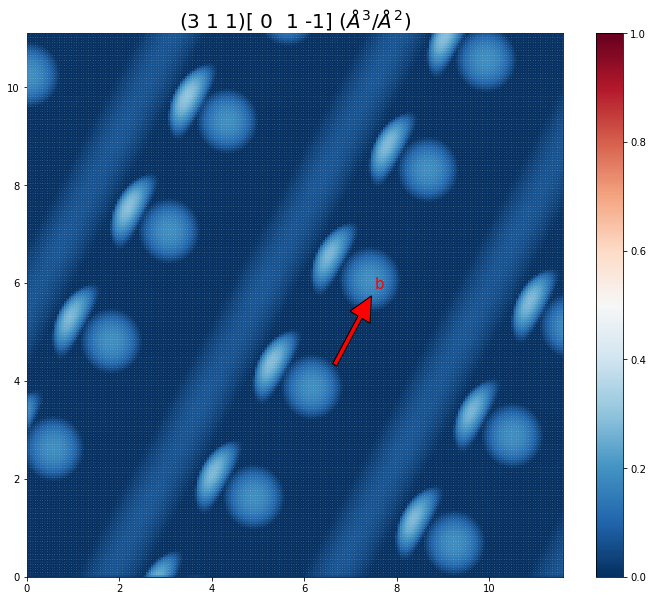

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,10))

#* Draw the slip direction
x_min, x_max = np.min(cart_target[:,0]), np.max(cart_target[:,0])
y_min, y_max = np.min(cart_target[:,1]), np.max(cart_target[:,1])
x_mid, y_mid = (x_min+x_max)/2, (y_min+y_max)/2
k = slip_vector_[1]/slip_vector_[0]
b = y_mid-k*x_mid
dx_vector = (x_max-x_mid)/4
dy_vector = dx_vector*k

dx_vector, dy_vector = dx_vector/np.linalg.norm([dx_vector, dy_vector]), dy_vector/np.linalg.norm([dx_vector, dy_vector])
dx_vector *= math.sqrt(burgers_vector)
dy_vector *= math.sqrt(burgers_vector)

plt.arrow(x_mid, y_mid, dx_vector, dy_vector, zorder=10, facecolor='r',
        width=0.1, head_width=0.5, head_length=0.5, length_includes_head=True)

#* Define area for illustration.
x_min_plot, x_max_plot = np.min(cart_cartesian_raw[:,0]), np.max(cart_cartesian_raw[:,0])
y_min_plot, y_max_plot = np.min(cart_cartesian_raw[:,1]), np.max(cart_cartesian_raw[:,1])
plt.xlim(x_min_plot, x_max_plot)
plt.ylim(y_min_plot, y_max_plot)

x_, y_ = x_specify_plot, y_specify_plot
c_ = volume_specify_list

#* Map values specifically to colorbar
cmap = plt.cm.get_cmap('RdBu_r')
norm = Normalize(vmin=0, vmax=1)

scatter = plt.scatter(x_, y_, c=c_, cmap=cmap, norm=norm, s=5, zorder=9)
plt.annotate(f'b', (x_mid+dx_vector*1.1, y_mid+dy_vector*1.1), 
             fontsize=15, zorder=10, color='r')

cbar = plt.colorbar(scatter,)

plt.title(f'({str(c_target)[1:-1]}){str(slip_vector_001)} ($\AA^3/\AA^2$)', fontsize=20)

plt.show()

For the intergration of volume.

In [ ]:
# #! Workplace
dict_grid_raw = copy.deepcopy(dict_grid)
dict_grid_raw = volume_image(cart_bot, dict_grid_raw)

dict_grid_targetraw = copy.deepcopy(dict_grid)
dict_grid_targetraw = volume_image(cart_target, dict_grid_targetraw)

for ds_i in range(ds_num):
    cart_target_ = cart_target.copy()
    cart_image = cart_target_ + ds_i*ds_
    #* Calibration of cell by PBC.
    cart_image = pbc_calib(cart_image, fcc_matrix)
    dict_grid = volume_image(cart_image, dict_grid)

#* Multiprocessing for image per step.
# def main(ds_i):
#     dict_grid_ = dict_grid.copy()
#     cart_target_ = cart_target.copy()
#     cart_image = cart_target_ + ds_i*ds_
#     #* Calibration of cell by PBC.
#     cart_image = pbc_calib(cart_image, fcc_matrix)
#     dict_grid_ = volume_image(cart_image, dict_grid_)
    
#     if ds_i % 50 == 0:
#         print(f'{ds_i} finished.')
    
#     return dict_grid_

# max_work = 8
# with concurrent.futures.ProcessPoolExecutor(max_workers=max_work) as executor:
#     dict_grid_images = executor.map(main, range(ds_num))

dict_grid_key = dict_grid.keys()
dict_grid_fin, dict_grid_raw_fin, dict_grid_targetraw_fin = {}, {}, {}
for key in list(dict_grid_key):
    key_x = np.sum(key[:2])/2
    key_y = np.sum(key[2:])/2
    
    dict_grid_fin[key_x, key_y] = dict_grid[key]
    dict_grid_raw_fin[key_x, key_y] = dict_grid_raw[key]
    dict_grid_targetraw_fin[key_x, key_y] = dict_grid_targetraw[key]

#* If overlap: then count 
dict_grid_overlap_fin = {}
for key in list(dict_grid_fin.keys()):
    if dict_grid_raw_fin[key] > 0:
        dict_grid_overlap_fin[key] = dict_grid_fin[key]
    
x_list_plot, y_list_plot, volume_list, volume_list_raw, volume_list_targetraw, \
    volume_list_slip, volume_list_frac, volume_list_overlap \
        = [], [], [], [], [], [], [], []
for key, value in dict_grid_fin.items():
    x_list_plot.append(key[0])
    y_list_plot.append(key[1])
    # volume_list.append(value/ds_num)
    volume_density = value/ds_num+dict_grid_raw_fin[key]
    volume_list.append(volume_density)
    volume_list_raw.append(dict_grid_raw_fin[key])
    volume_list_targetraw.append(dict_grid_targetraw_fin[key])
    volume_list_slip.append(value/ds_num)
    volume_list_frac.append(volume_density/2/layer_distance)
    volume_list_overlap.append(dict_grid_overlap_fin.get(key, 0)/ds_num+dict_grid_raw_fin[key])
    # volume_list.append(dict_grid_raw_fin[key])